# Evaluating LLMs with labeled data

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kluster-ai/klusterai-cookbook/blob/main/examples/model-comparison.ipynb)

How can you know which LLM is better for a given task? Choosing the right LLM for your specific use case is crucial but challenging. While larger models generally offer better performance, they often come with higher costs.

This tutorial walks through a notebook where you'll learn how to systematically evaluate Large Language Models (LLMs) using the <a href="https://kluster.ai/" target="_blank">kluster.ai</a> batch API, showcasing a practical example of comparing different models for a real-world task. The systematic evaluation pipeline does the following:

1. Loads and processes a public dataset (which you can later replace with your own).
2. Tests three state-of-the-art models on a text classification task.
3. Compares their accuracy using annotated data.
4. Helps you make an informed decision based on both performance and cost.

You'll be using the same dataset as in our <a href="/tutorials/klusterai-api/text-classification/text-classification-openai-api/" target="_blank">text classification notebook</a>, which is an extract from the IMDB top 1000 movies dataset categorized into 21 different genres.

## Understanding accuracy in model evaluation

Before we compare machine learning models, it’s important to understand the evaluation metric we’ll be using: accuracy.

In machine learning, accuracy is one of the simplest and most commonly used performance metrics, especially for classification problems. It gives us a quick sense of how often the model gets things right.

Accuracy is calculated by taking the number of correct predictions and dividing it by the total number of predictions. For example, if a model correctly classifies 85 out of 100 movie genres, its accuracy would be 85%.

$$ \text{Accuracy} = \frac{\text{Number of Correct Classifications}}{\text{Total Number of Classifications}} $$

We're choosing accuracy for this tutorial because:

1. It's easy to understand and interpret.
2. It directly answers the question: "How often is our model correct?"

In the next section, we'll see how to implement this metric in our evaluation pipeline.

## Prerequisites

Before getting started, ensure you have the following:

- **A kluster.ai account**: Sign up on the <a href="https://platform.kluster.ai/signup" target="_blank">kluster.ai platform</a> if you don't have one.
- **A kluster.ai API key**: After signing in, go to the <a href="https://platform.kluster.ai/apikeys" target="_blank">**API Keys**</a> section and create a new key. For detailed instructions, check out the <a href="/get-started/get-api-key/" target="_blank">Get an API key</a> guide.

## Setup

In this notebook, we'll use Python's `getpass` module to input the key safely. After execution, please provide your unique kluster.ai API key (ensure no spaces).

In [1]:
from getpass import getpass

api_key = getpass("Enter your kluster.ai API key: ")

Enter your kluster.ai API key:  ········


Next, ensure you've installed the OpenAI Python library:

In [2]:
%pip install -q OpenAI

Note: you may need to restart the kernel to use updated packages.


With the OpenAI Python library installed, we import the necessary dependencies for the tutorial:

In [3]:
from openai import OpenAI

import pandas as pd
import time
import json
import os
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import urllib.request
import numpy as np

Then, initialize the `client` by pointing it to the kluster.ai endpoint and passing your API key.


In [4]:
# Set up the client
client = OpenAI(
    base_url="https://api.kluster.ai/v1",
    api_key=api_key,
)

## Get the data

Now that you've initialized an OpenAI-compatible client pointing to kluster.ai, we can talk about the data.

This notebook uses a dataset from the Top 1000 IMDb Movies dataset, which contains descriptions and genres for each movie. In some cases, a movie can have more than one label. When calculating the accuracy, we'll consider the prediction correct if the predicted genre matches at least one of the genres listed in the dataset, the ground truth. This ground truth allows the notebook to calculate the accuracy and measure how well a given LLM has performed.


In [5]:
# IMDB Top 1000 dataset:
url = "https://raw.githubusercontent.com/kluster-ai/klusterai-cookbook/refs/heads/main/data/imdb_top_1000.csv"
urllib.request.urlretrieve(url,filename='imdb_top_1000.csv')

# Load and process the dataset based on URL content
df = pd.read_csv('imdb_top_1000.csv', usecols=['Series_Title', 'Overview', 'Genre'])
df.head(3)

,Series_Title,Genre,Overview
0,The Shawshank Redemption,Drama,Two imprisoned men bond over a number of years...
1,The Godfather,"Crime, Drama",An organized crime dynasty's aging patriarch t...
2,The Dark Knight,"Action, Crime, Drama",When the menace known as the Joker wreaks havo...


## Perform batch inference

To execute the batch inference job, we'll take the following steps:

1. **Create the batch job file**: We'll generate a JSON lines file with the desired requests to be processed by the model.
2. **Upload the batch job file**: Once it is ready, we'll upload it to the <a href="https://platform.kluster.ai/signup" target="_blank">kluster.ai platform</a> using the API, where it will be processed. We'll receive a unique ID associated with our file.
3. **Start the batch job**: After the file is uploaded, we'll initiate the job to process the uploaded data, using the file ID obtained before.
4. **Monitor job progress (optional)**: Track the status of the batch job to ensure it has been successfully completed.
5. **Retrieve results**: Once the job has completed execution, we can access and process the resultant data.

This notebook is prepared for you to follow along. Run the cells below to watch it all come together.

### Create the batch job file

This example compares the DeepSeek V3 0324, Llama 4 Maverick 17B 128E, Llama 4 Scout 17B 16E, and Gemma 3 27B models. If you'd like to test different models, feel free to modify the scripts accordingly. DeepSeek R1 was excluded from the comparison, as it consistently returned verbose responses despite multiple attempts to adjust the system prompt.

Please refer to the <a href="/get-started/models/#model-comparison-table" target="_blank">Supported models</a> section for a list of the models we support.

The following snippets prepare the JSONL file, where each line represents a different request. Note that each separate batch request can have its own model. Also, we are using a temperature of `0.5`, but feel free to change it and play around with the different outcomes (but we are only asking to respond with a single word, the genre).

In [6]:
# System prompt
SYSTEM_PROMPT = """
    You are a helpful assistant that classifies movie genres based on the movie description. Your response must be one of these exact words and nothing else: 
    Action, Adventure, Animation, Biography, Comedy, Crime, Drama, Family, Fantasy, Film-Noir, History, Horror, Music, Musical, Mystery, Romance, Sci-Fi, Sport, Thriller, War, Western.
    Respond with ONE WORD ONLY. No punctuation, no explanation, no formatting. Just the genre.
    """

# Models
models = {
    "DeepSeek-V3-0324": "deepseek-ai/DeepSeek-V3-0324",
    "Llama4-Maverick-17B": "meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8",
    "Llama4-Scout-17B": "meta-llama/Llama-4-Scout-17B-16E-Instruct",
    "Gemma3-27B": "google/gemma-3-27b-it",
}

# Ensure the directory exists
os.makedirs("model_comparison", exist_ok=True)

# Create the batch job file with the prompt and content for the model
def create_batch_file(model):
    batch_list = []
    
    for index, row in df.iterrows():
        content = row["Overview"]

        request = {
            "custom_id": f"{model}-{index}-analysis",
            "method": "POST",
            "url": "/v1/chat/completions",
            "body": {
                "model": models[model],
                "temperature": 0.5,
                "messages": [
                    {"role": "system", "content": SYSTEM_PROMPT},
                    {"role": "user", "content": content},
                ],
            },
        }
        
        batch_list.append(request)

    return batch_list


# Save file
def save_batch_file(batch_list, model):
    filename = f"model_comparison/batch_job_{model}_request.jsonl"
    with open(filename, "w") as file:
        for request in batch_list:
            file.write(json.dumps(request) + "\n")
    return filename


Let's run the functions we've defined before:

In [7]:
filenames = []

# Loop through each model and save the batch files
for model in models:
    batch_request = create_batch_file(model)
    filename = save_batch_file(batch_request, model)
    filenames.append(filename)
    print(filename)


model_comparison/batch_job_DeepSeek-V3-0324_request.jsonl
model_comparison/batch_job_Llama4-Maverick-17B_request.jsonl
model_comparison/batch_job_Llama4-Scout-17B_request.jsonl
model_comparison/batch_job_Gemma3-27B_request.jsonl


Next, we can preview what one of the requests in a batch job files looks like:

In [8]:
!head -n 1 model_comparison/batch_job_DeepSeek-V3-0324_request.jsonl

{"custom_id": "DeepSeek-V3-0324-0-analysis", "method": "POST", "url": "/v1/chat/completions", "body": {"model": "deepseek-ai/DeepSeek-V3-0324", "temperature": 0.5, "messages": [{"role": "system", "content": "\n    You are a helpful assistant that classifies movie genres based on the movie description. Your response must be one of these exact words and nothing else: \n    Action, Adventure, Animation, Biography, Comedy, Crime, Drama, Family, Fantasy, Film-Noir, History, Horror, Music, Musical, Mystery, Romance, Sci-Fi, Sport, Thriller, War, Western.\n    Respond with ONE WORD ONLY. No punctuation, no explanation, no formatting. Just the genre.\n    "}, {"role": "user", "content": "Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency."}]}}


### Upload batch job file to kluster.ai

Now that we've prepared our input files, it's time to upload them to the kluster.ai platform. To do so, you can use the `files.create` endpoint of the client, where the purpose is set to `batch`. This will return the file ID, which we need to log for the next steps. We will repeat the process for each batch file created.

In [9]:
def upload_batch_file(data_dir):
  print(f"Creating request for {data_dir}")
  
  with open(data_dir, 'rb') as file:
    upload_response = client.files.create(
    file=file,
    purpose="batch"
  )

  # Print job ID
  file_id = upload_response.id
  print(f"File uploaded successfully. File ID: {file_id}")

  return upload_response

In [10]:
batch_files = []

# Loop through all .jsonl files in the data folder
for data_dir in filenames:
    print(f"Uploading file {data_dir}")
    job = upload_batch_file(data_dir)
    batch_files.append(job)

Uploading file model_comparison/batch_job_DeepSeek-V3-0324_request.jsonl
Creating request for model_comparison/batch_job_DeepSeek-V3-0324_request.jsonl
File uploaded successfully. File ID: 680c01630f76b6b2cfa1b5ce
Uploading file model_comparison/batch_job_Llama4-Maverick-17B_request.jsonl
Creating request for model_comparison/batch_job_Llama4-Maverick-17B_request.jsonl
File uploaded successfully. File ID: 680c01645e828dbbaf25e0e4
Uploading file model_comparison/batch_job_Llama4-Scout-17B_request.jsonl
Creating request for model_comparison/batch_job_Llama4-Scout-17B_request.jsonl
File uploaded successfully. File ID: 680c0164f5af163532d24930
Uploading file model_comparison/batch_job_Gemma3-27B_request.jsonl
Creating request for model_comparison/batch_job_Gemma3-27B_request.jsonl
File uploaded successfully. File ID: 680c0165d7dcc4753cb1f640


All files are now uploaded, and we can proceed with creating the batch jobs.

### Start the job

Once all the files have been successfully uploaded, we're ready to start (create) the batch jobs by providing the file ID of each file, which we got in the previous step. To start each job, we use the `batches.create` method, for which we need to set the endpoint to `/v1/chat/completions`. This will return each batch job details, with each ID.

In [11]:
# Create batch job with completions endpoint
def create_batch_job(file_id):
  batch_job = client.batches.create(
    input_file_id=file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h"
  )

  print(f"Batch job created with ID {batch_job.id}")
  return batch_job

In [12]:
batch_jobs = []

# Loop through all batch files ID and start each job
for batch_file in batch_files:
    print(f"Creating batch job for file ID {batch_file.id}")
    batch_job = create_batch_job(batch_file.id)
    batch_jobs.append(batch_job)

Creating batch job for file ID 680c01630f76b6b2cfa1b5ce
Batch job created with ID 680c01678b52512099d68fe7
Creating batch job for file ID 680c01645e828dbbaf25e0e4
Batch job created with ID 680c0167bc5b5b56242bd0f6
Creating batch job for file ID 680c0164f5af163532d24930
Batch job created with ID 680c0167ba6dc89c0537e9ce
Creating batch job for file ID 680c0165d7dcc4753cb1f640
Batch job created with ID 680c0167514e8aab967a5bfe


All requests are queued to be processed.

### Check job progress

Now that your batch jobs have been created, you can track their progress.

To monitor the job's progress, we can use the `batches.retrieve` method and pass the batch job ID. The response contains a `status` field that tells whether it is completed and the subsequent status of each job separately. We can repeat this process for every batch job ID we get in the previous step.

The following snippet checks the status of all batch jobs every 10 seconds until the entire batch is completed.

In [13]:
def monitor_batch_jobs(batch_jobs):
    all_completed = False

    # Loop until all jobs are completed
    while not all_completed:
        all_completed = True
        output_lines = []

        # Loop through all batch jobs
        for job in batch_jobs:
            updated_job = client.batches.retrieve(job.id)
            status = updated_job.status

            # If job is completed
            if status == "completed":
                output_lines.append("Job completed!")
            # If job failed, cancelled or expired
            elif status in ["failed", "cancelled", "expired"]:
                output_lines.append(f"Job ended with status: {status}")
                break
            # If job is ongoing
            else:
                all_completed = False
                completed = updated_job.request_counts.completed
                total = updated_job.request_counts.total
                output_lines.append(
                    f"Job status: {status} - Progress: {completed}/{total}"
                )

        # Clear terminal
        clear_output(wait=True)
        for line in output_lines:
            display(line)

        # Check every 10 seconds
        if not all_completed:
            time.sleep(10)


In [14]:
monitor_batch_jobs(batch_jobs)

'Job completed!'

'Job completed!'

'Job completed!'

'Job completed!'

## Get the results

With all jobs completed, we'll retrieve the results and review the responses generated for each request. The results are parsed. To fetch the results from the platform, you must retrieve the `output_file_id` from the batch job and then use the `files.content` endpoint, providing that specific file ID. We will repeat this for every single batch job id. Note that the job status must be `completed` to retrieve the results!

In [15]:
#Parse results as a JSON object
def parse_json_objects(data_string):
  if isinstance(data_string, bytes):
    data_string = data_string.decode('utf-8')

  json_strings = data_string.strip().split('\n')
  json_objects = []

  for json_str in json_strings:
    try:
      json_obj = json.loads(json_str)
      json_objects.append(json_obj)
    except json.JSONDecodeError as e:
      print(f"Error parsing JSON: {e}")

  return json_objects

In [16]:
# Token usage per model
token_usage = {}

# Pricing at the time of writing
pricing = {
    "DeepSeek-V3-0324": {"input": 0.70, "output": 1.40},
    "Llama4-Maverick-17B": {"input": 0.20, "output": 0.80},
    "Llama4-Scout-17B": {"input": 0.80, "output": 0.45},
    "Gemma3-27B": {"input": 0.35, "output": 0.35},
}


# Go through all batch jobs, providing the output file ID
for batch_job in batch_jobs:
    job_status = client.batches.retrieve(batch_job.id)
    result_file_id = job_status.output_file_id
    result = client.files.content(result_file_id).content
    results = parse_json_objects(result)

    # Extract model name from the response
    model_path = results[0]['response']['body']['model']
    model = next(k for k, v in models.items() if v == model_path)

    # Initialize counters for this model
    total_prompt_tokens = 0
    total_completion_tokens = 0

    answers = []
    for res in results:
        # Get answer
        answer = res['response']['body']['choices'][0]['message']['content']
        answers.append(answer)

        # Accumulate tokens
        usage = res['response']['body']['usage']
        total_prompt_tokens += usage.get('prompt_tokens', 0)
        total_completion_tokens += usage.get('completion_tokens', 0)

    # Save answers to DataFrame
    df[f'{model}_genre'] = answers

    # Calculate cost (per million tokens)
    input_price = pricing[model]['input']
    output_price = pricing[model]['output']
    cost = (total_prompt_tokens / 1_000_000) * input_price + (total_completion_tokens / 1_000_000) * output_price

    # Store token and cost data
    token_usage[model] = {
        'total_prompt_tokens': total_prompt_tokens,
        'total_completion_tokens': total_completion_tokens,
        'total_cost_usd': round(cost, 4)
    }


## Analyze the results

With all models evaluated, we can analyze their performance. The graph below shows the accuracy scores for each model we tested. 

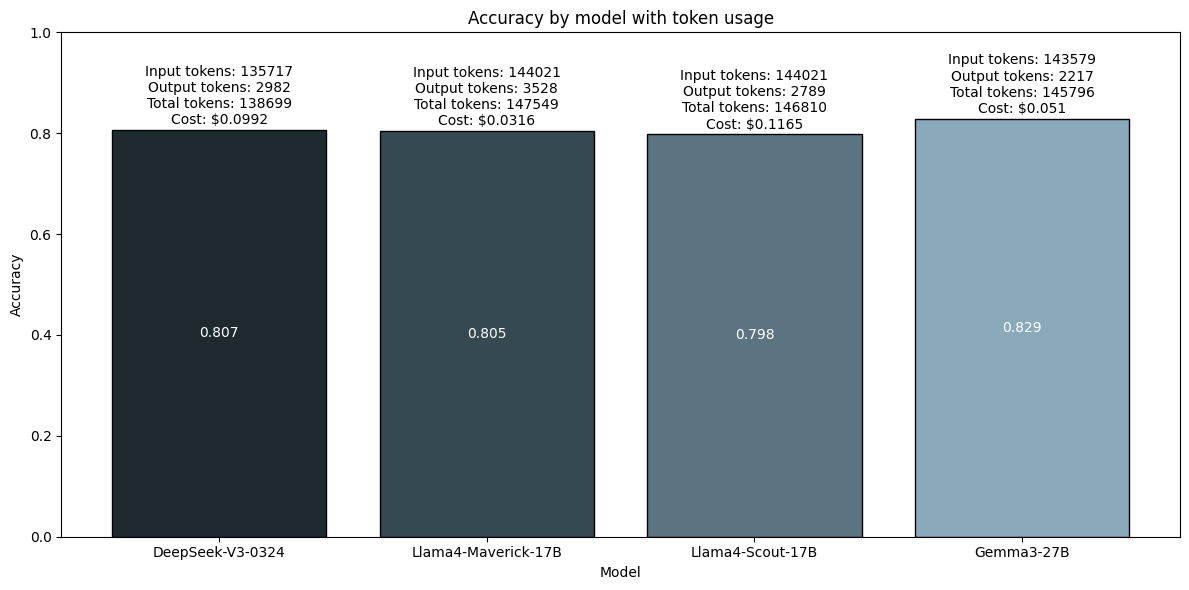

In [17]:
# Calculate accuracy
accuracies = {}
for model in models:
    accuracy = df.apply(lambda row: row[f'{model}_genre'] in row['Genre'].split(', '), axis=1).mean()
    accuracies[model] = accuracy

# Plot colors
colors = ['#1E2A30', '#354953', '#5C7482', '#8AA9BB']

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(accuracies.keys(), accuracies.values(), color=colors, edgecolor='black')
ax.bar_label(bars, label_type='center', color='white', fmt="%.3f")

# Add token usage as text above bars
for bar, model in zip(bars, accuracies.keys()):
    prompt_tokens = token_usage[model]['total_prompt_tokens']
    completion_tokens = token_usage[model]['total_completion_tokens']
    cost = token_usage[model]['total_cost_usd']

    # Positioning text above the bar
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.005,
        f"Input tokens: {prompt_tokens}\nOutput tokens: {completion_tokens}\nTotal tokens: {prompt_tokens+completion_tokens}\nCost: ${cost}",
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

# Labels and title
ax.set_ylim(0, 1)
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by model with token usage')

plt.tight_layout()
plt.show()

The analysis shows that Gemma 3 27B achieved the highest classification accuracy at 82.9%, making it the top-performing model on this task. Despite consuming the largest number of tokens, its flat-rate pricing model helped it maintain a low overall cost ($0.051), placing it as the second cheapest model in the evaluation. This balance of performance and affordability makes it a strong candidate for accuracy-sensitive applications where moderate cost is acceptable.

Llama 4 Maverick 17B stood out as the most cost-effective model. It delivered a solid 80.5% accuracy while incurring the lowest total cost of just $0.0316 — nearly half the cost of Gemma 3. For use cases that prioritize efficiency, scalability, and cost-sensitivity (e.g., high-volume inference or real-time pipelines), Maverick offers exceptional value.

Llama 4 Scout 17B showed worse accuracy (79.8%) than Maverick but at a higher price point ($0.1165). This model might be appropriate in other scenarios where it can yield better results, such as tasks involving ambiguity or subtle classification differences. However, its cost-efficiency ratio lags behind both Maverick and Gemma.

DeepSeek V3 0324 had a similar accuracy to both Maverick and Scout, while also incurring the highest cost ($0.0992), suggesting that in this specific context, it may not be the most competitive choice when weighed against either cost or performance alone. 

That said, these results should not be generalized without further testing on different types of tasks and prompts, as they are limited to the dataset and classification task used (genre classification using movie overviews from the IMDb Top 1000 dataset). The models may behave differently on other types of content (for example, dialogue-heavy text, short prompts, technical content), and their relative performance could shift depending on task complexity, prompt structure, or label distribution.

## Summary

This tutorial used the chat completion endpoint to perform genre classification on movie descriptions from the IMDb Top 1000 dataset using the kluster.ai batch API. We tested four models, comparing them based on accuracy, token usage, and cost. For the notebook run recorded:

- DeepSeek V3 0324:
  - Accuracy: 80.7%
  - Total tokens used: 138,699 (135,717 input / 2,982 output)
  - Cost: $0.0992
  - Highest cost among the four models ❌

- Llama 4 Maverick 17B:
  - Accuracy: 80.5%
  - Total tokens used: 147,549 (144,021 input / 3,528 output)
  - Cost: $0.0316 ✅
  - Best overall cost-efficiency, delivering solid performance at the lowest price

- Llama 4 Scout 17B:
  - Accuracy: 79.8%
  - Total tokens used: 146,810 (144,021 input / 2,789 output)
  - Cost: $0.1165
  - Slightly lower accuracy compared to Maverick, but significantly more expensive

- Gemma 3 27B:
  - Accuracy: 82.9% ✅
  - Total tokens used: 145,796 (143,579 input / 2,217 output)
  - Best overall ratio between cost-efficiency and accuracy


Each model was evaluated using the same set of 1000 movie overviews, with genre predictions compared against annotated ground-truth genres. Total input and output tokens were recorded and converted into USD using published prices per 1M tokens.

To submit and evaluate the batch jobs, we:

1. Created the JSONL file, where each file line represented a separate request.
2. Submitted the file to the platform.
3. Started the batch job and monitored its progress.
4. Once completed, we fetched the results.

The results were then visualized in a bar chart showing **accuracy**, **token usage**, and **cost per model**, allowing for a clear comparison of trade-offs between quality and efficiency.

All of this using the OpenAI Python library and API, no changes needed!

As a next step, consider testing additional models, experimenting with prompt engineering, or applying the same evaluation strategy to your own dataset. Happy experimenting!
